In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [17]:
# Load & Preprocess the data
df = pd.read_csv(
    'combined_dataset.csv',
    engine='python',
    on_bad_lines='skip'
)

In [18]:
print(df['pixels'].head(5).tolist())


['[164, 164, 164, 164, 163, 163, 163, 163, 164, 164, 163, 163, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 163, 163, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 161, 163, 164, 163, 163, 162, 164, 164, 166, 164, 164, 166, 166, 166, 163, 162, 166, 165, 164, 164, 164, 165, 163, 163, 165, 167, 163, 164, 165, 163, 163, 163, 160, 163, 160, 163, 163, 160, 163, 164, 163, 162, 162, 155, 164, 164, 164, 164, 145, 126, 129, 129, 128, 128, 127, 125, 117, 114, 114, 115, 115, 115, 113, 113, 113, 112, 111, 112, 113, 115, 117, 118, 120, 122, 126, 126, 125, 126, 128, 129, 130, 131, 130, 132, 130, 128, 125, 127, 123, 122, 127, 141, 162, 163, 164, 164, 145, 135, 136, 136, 137, 135, 135, 132, 127, 122, 123, 122, 122, 122, 120, 120, 119, 118, 117, 119, 120, 122, 122, 122, 124, 127, 129, 132, 133, 133, 133, 135, 135, 135, 135, 134, 132, 130, 131, 130, 128, 128, 128, 142, 164, 163, 163, 164, 149, 136, 140, 140, 138, 13

In [20]:
import ast

X = df['pixels'].apply(lambda x: np.array(ast.literal_eval(x)))
X = np.stack(X, axis=0)
X = X.reshape(-1, 48, 48, 1)
X = X / 255.0


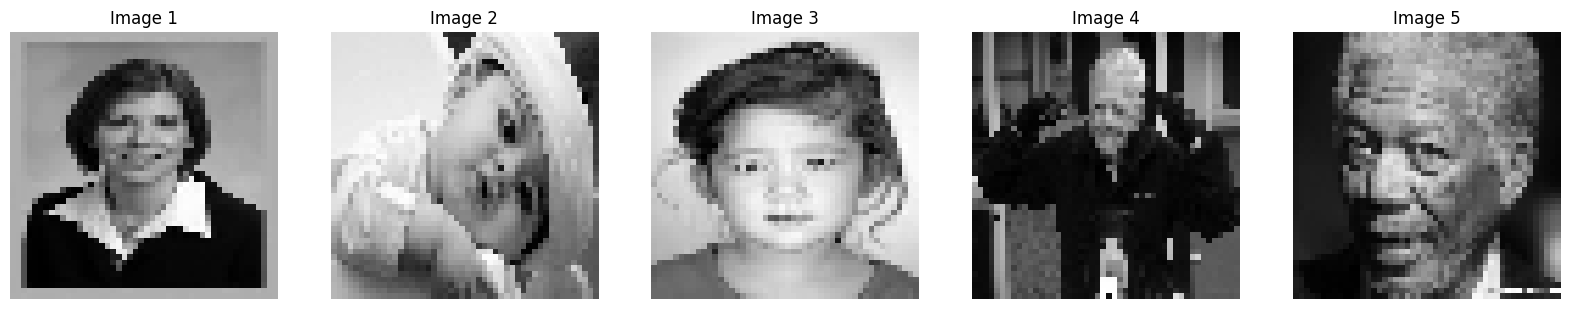

In [21]:
# Image Visualization Check
fig,axes = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axes[i].imshow(X[i, :, :, 0], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')
plt.show()

In [22]:
# Normalize age to 0 - 1
# Gender to 2 classes
# Ethnicity to 5 classes

y_age = df['age'].astype('float32')
y_gender = to_categorical(df['gender'], num_classes = 2)
y_ethnicity = to_categorical(df['ethnicity'], num_classes = 5)

In [23]:
# Train & Test sets
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test, y_eth_train, y_eth_test = train_test_split(
    X, y_age, y_gender, y_ethnicity,
    test_size=0.2,
    random_state=42
)

In [24]:
#CNN
def ConvFunc(x, filters=32, kernel_size=(3, 3), dropout_rate=0.1):
    x = Conv2D(
        filters,
        kernel_size=kernel_size,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(0.001)
    )(x)

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(dropout_rate)(x)
    return x

In [25]:
from tensorflow.keras.layers import Activation
def swish(x):
    return x * tf.nn.sigmoid(x)

In [26]:
#Multi-feature Model
def build_multi_feature_model():
    inputs = Input(shape=(48, 48, 1))

    #Convolutional Layers
    x = ConvFunc(inputs, 32, dropout_rate=0.1)
    x = ConvFunc(x, 64, dropout_rate=0.15)
    x = ConvFunc(x, 128, dropout_rate=0.2)
    x = ConvFunc(x, 256, dropout_rate=0.25)
    x = Flatten()(x)

    #Age
    age_branch = Dense(256)(x)
    age_branch = Activation(swish)(age_branch)
    age_branch = Dropout(0.4)(age_branch)
    age_output = Dense(1, activation="softplus", name = 'age_output')(age_branch)

    #Gender
    gender_branch = Dense(256, activation="relu")(x)
    gender_branch = Dropout(0.4)(gender_branch)
    gender_output = Dense(2, activation="softmax", name = 'gender_output')(gender_branch)

    #Ethnicity
    ethnicity_branch = Dense(256, activation="relu")(x)
    ethnicity_branch = Dropout(0.4)(ethnicity_branch)
    ethnicity_output = Dense(5, activation="softmax", name = 'ethnicity_output')(ethnicity_branch)

    model = Model(inputs, [age_output, gender_output, ethnicity_output])
    return model

multi_feature_model = build_multi_feature_model()

In [27]:
# Compile Model
multi_feature_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss={
        'age_output': tf.keras.losses.Huber(delta=2.0),
        'gender_output': tf.keras.losses.BinaryCrossentropy(),
        'ethnicity_output': tf.keras.losses.CategoricalCrossentropy()
    },
    loss_weights={
        'age_output': 1.5,
        'gender_output': 1,
        'ethnicity_output': 2
    },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    }
)
multi_feature_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 6, 6, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 256) │    295,168 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,162,056 (8.25 MB)

 Trainable params: 2,161,096 (8.24 MB)

 Non-trainable params: 960 (3.75 KB)

In [28]:
#Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=5, verbose=1, factor=0.5, min_lr=1e-5
)

multi_feature_model.fit(
    X_train,
    {
        'age_output': y_age_train,
        'gender_output': y_gender_train,
        'ethnicity_output': y_eth_train
    },
    validation_data=(
        X_test,
        {
            'age_output': y_age_test,
            'gender_output': y_gender_test,
            'ethnicity_output': y_eth_test
        }
    ),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - age_output_loss: 32.9608 - age_output_mae: 17.4509 - ethnicity_output_accuracy: 0.4030 - ethnicity_output_loss: 1.6824 - gender_output_accuracy: 0.5717 - gender_output_loss: 0.7845 - loss: 54.5552 - val_age_output_loss: 35.9291 - val_age_output_mae: 18.9454 - val_ethnicity_output_accuracy: 0.4879 - val_ethnicity_output_loss: 1.3753 - val_gender_output_accuracy: 0.6401 - val_gender_output_loss: 0.6402 - val_loss: 58.2487 - learning_rate: 2.0000e-04
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - age_output_loss: 26.0955 - age_output_mae: 14.0103 - ethnicity_output_accuracy: 0.4798 - ethnicity_output_loss: 1.3302 - gender_output_accuracy: 0.6398 - gender_output_loss: 0.6312 - loss: 43.3982 - val_age_output_loss: 26.2712 - val_age_output_mae: 14.0921 - val_ethnicity_output_accuracy: 0.5164 - val_ethnicity_output_loss: 1.2606 - val_gender_output_accuracy: 0.6642 - val_gender_output_loss: 0.5959 - val_loss: 43.4848 - learning

In [29]:
#Evaluation
evaluation = multi_feature_model.evaluate(X_test, {
    'age_output': y_age_test,
    'gender_output': y_gender_test,
    'ethnicity_output': y_eth_test
})
print('Test Results:', evaluation)

212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - age_output_loss: 15.7891 - age_output_mae: 8.8247 - ethnicity_output_accuracy: 0.6484 - ethnicity_output_loss: 0.9219 - gender_output_accuracy: 0.7946 - gender_output_loss: 0.4153 - loss: 26.9011
Test Results: [26.8492431640625, 15.775030136108398, 0.40340790152549744, 0.9088318347930908, 8.8181791305542, 0.6578013896942139, 0.7992021441459656]


In [30]:
#Evaluation Table
metric_names = [
    'Total Loss (weighted)',
    'Age Loss (Huber)',
    'Gender Loss (Crossentropy)',
    'Ethnicity Loss (Crossentropy)',
    'Age MAE (years)',
    'Ethnicity Accuracy',
    'Gender Accuracy'
]

print("\n📊 Model Evaluation Results:")
print("-" * 50)
for name, value in zip(metric_names, evaluation):
    if "Accuracy" in name:
        print(f"{name:<35}: {value:.2%}")
    elif "MAE" in name:
        print(f"{name:<35}: {value:.4f}")

    else:
        print(f"{name:<35}: {value:.4f}")
print("-" * 50)


📊 Model Evaluation Results:
--------------------------------------------------
Total Loss (weighted)              : 26.8492
Age Loss (Huber)                   : 15.7750
Gender Loss (Crossentropy)         : 0.4034
Ethnicity Loss (Crossentropy)      : 0.9088
Age MAE (years)                    : 8.8182
Ethnicity Accuracy                 : 65.78%
Gender Accuracy                    : 79.92%
--------------------------------------------------


In [31]:
multi_feature_model.save("multi_feature_model_combined_data.h5")

In [33]:
from google.colab import files
files.download('multi_feature_model_combined_data.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>